# Testing for cointegration

## September 2022 - April 2024

In [1]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Fetch historical prices for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')['Close']
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')['Close']  # Adjusted end date for alignment

# Combine into a single DataFrame
prices = pd.DataFrame({'BTC': btc_data, 'ETH': eth_data}).dropna()

# Engle-Granger cointegration test
score, p_value, _ = coint(prices['BTC'], prices['ETH'])

# Display the test results
print(f"Cointegration test score: {score}")
print(f"P-value: {p_value}")

# Interpretation of results
if p_value < 0.05:
    print("The series are likely cointegrated.")
else:
    print("The series are not likely cointegrated.")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Cointegration test score: -3.590214895647519
P-value: 0.025192882623511305
The series are likely cointegrated.


# Lets model the spread between BTC and ETH and check for stationarity.


In [2]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Downloading the data
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Creating a DataFrame with both BTC and ETH closing prices
prices = pd.DataFrame({
    'BTC': btc_data['Close'],
    'ETH': eth_data['Close']
})

# Calculating the spread
prices['Spread'] = prices['BTC'] - prices['ETH']

# Standardizing the spread
prices['Standardized Spread'] = (prices['Spread'] - prices['Spread'].mean()) / prices['Spread'].std()

# Performing the Augmented Dickey-Fuller test
adf_result = adfuller(prices['Spread'].dropna())  # Ensure there are no NaN values

# Output the results of the ADF test
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if adf_result[1] < 0.05:
    print("The spread is stationary.")
else:
    print("The spread is not stationary.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ADF Statistic: 1.8950293234646305
p-value: 0.9985199797909801
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570
The spread is not stationary.


# Differencing to make the spread stationary

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ADF Statistic: -5.729555
p-value: 0.000001
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


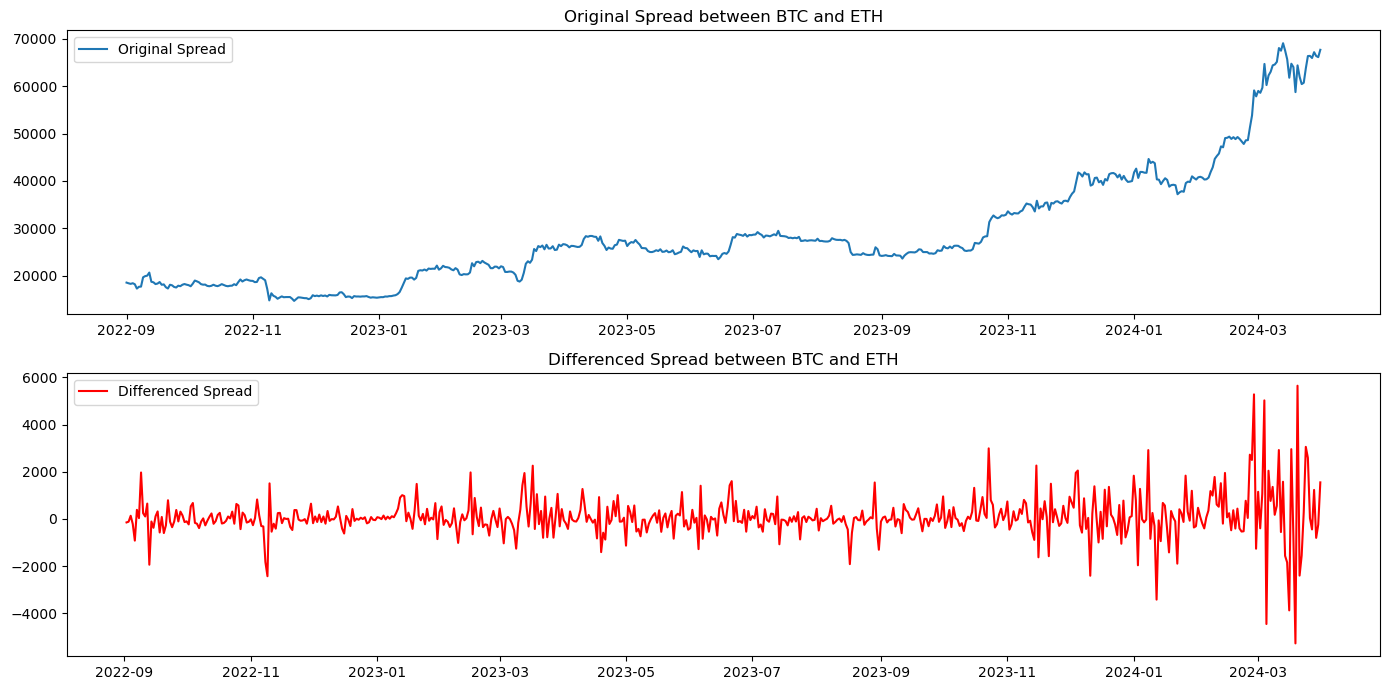

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Downloading the data
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Creating a DataFrame with both BTC and ETH closing prices
prices = pd.DataFrame({
    'BTC': btc_data['Close'],
    'ETH': eth_data['Close']
})

# Calculating the spread
prices['Spread'] = prices['BTC'] - prices['ETH']

# Differencing the spread to achieve stationarity
prices['Differenced Spread'] = prices['Spread'].diff().dropna()

# Ensure no NaNs before running ADF test
cleaned_diff_spread = prices['Differenced Spread'].dropna()

# Function to perform ADF Test and print results
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Performing ADF test on the cleaned, differenced spread
adf_test(cleaned_diff_spread)

# Plotting the original and differenced spread
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(prices['Spread'], label='Original Spread')
plt.title('Original Spread between BTC and ETH')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(prices['Differenced Spread'], label='Differenced Spread', color='red')
plt.title('Differenced Spread between BTC and ETH')
plt.legend()

plt.tight_layout()
plt.show()


# RF model

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


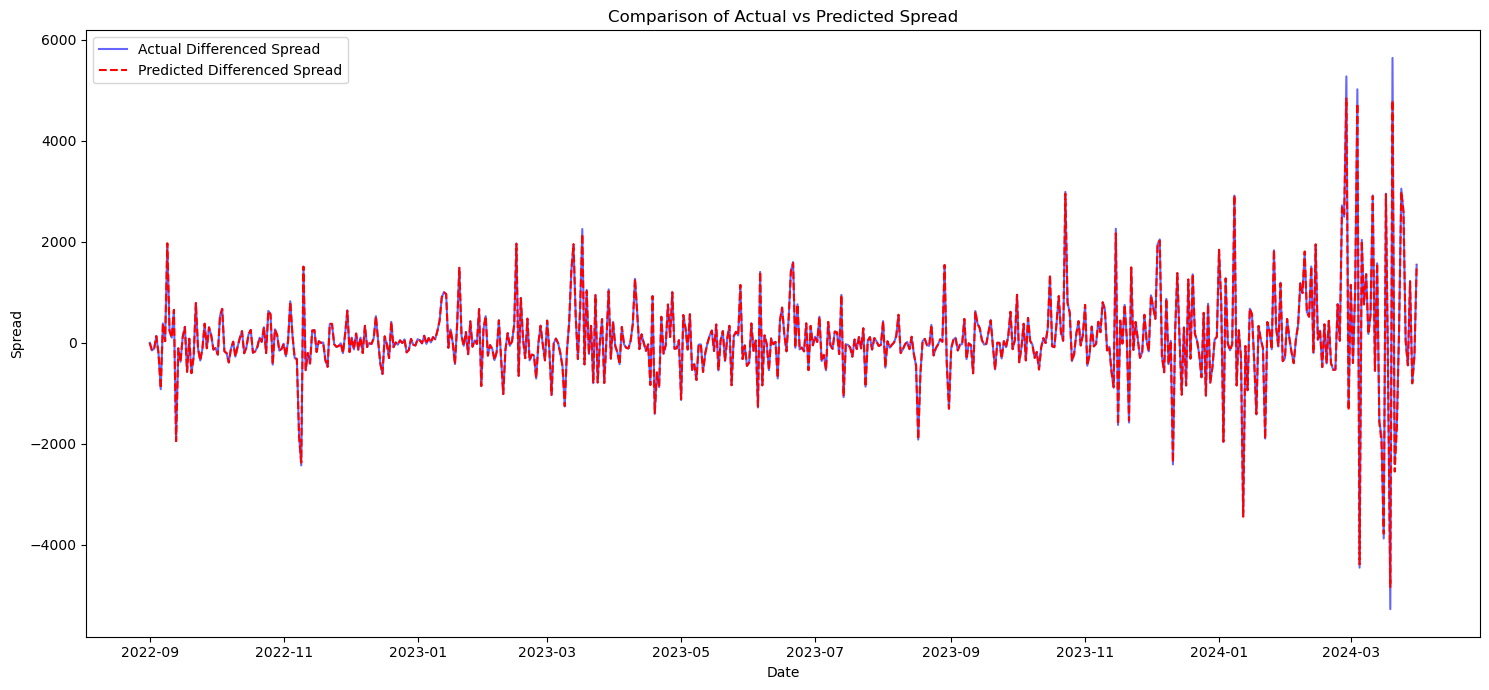

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['Volatility'] = market_data['Differenced_Spread'].rolling(window=5).std().fillna(0)

# Drop NaN created by rolling function and shifting
market_data = market_data.dropna()

# Split data for training and testing
X = market_data[['Differenced_Spread', 'Volatility']]
y = market_data['Differenced_Spread']  # Predict next day's spread
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Visualization to compare actual and predicted spread
plt.figure(figsize=(15, 7))
plt.plot(market_data.index, y, label='Actual Differenced Spread', color='blue', alpha=0.6)
plt.plot(market_data.index, market_data['predicted_spread'], label='Predicted Differenced Spread', color='red', linestyle='--')
plt.title('Comparison of Actual vs Predicted Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.tight_layout()

plt.show()


In [5]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# First, calculate the residuals from your Random Forest model
# Since you predicted the 'predicted_spread' directly, we assume y_test and the predictions are aligned in the index
residuals = y_test - rf_model.predict(X_test)

# Add a constant to the independent variables for the test
X_test_with_const = sm.add_constant(X_test)

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_test_with_const)

# Extract the test results
bp_test_stat, bp_p_value, bp_f_stat, bp_f_p_value = bp_test

# Print the results
print("Breusch-Pagan test statistic:", bp_test_stat)
print("Breusch-Pagan test p-value:", bp_p_value)
print("Breusch-Pagan F-statistic:", bp_f_stat)
print("Breusch-Pagan F-test p-value:", bp_f_p_value)

Breusch-Pagan test statistic: 61.044715359240804
Breusch-Pagan test p-value: 5.5501981082209896e-14
Breusch-Pagan F-statistic: 62.76059600715877
Breusch-Pagan F-test p-value: 4.662922433254873e-19


# EGRCH MODEL SELECTION

In [6]:
import numpy as np
from arch import arch_model


# Assuming 'residuals' is a pre-defined series of residuals from your Random Forest model
# Initialize placeholders for the best AIC, BIC, and model configurations
best_aic, best_bic = np.inf, np.inf
best_cfg = None
best_model = None

# Loop over potential orders for the EGARCH model
for p in range(1, 4):  # You can adjust the range based on your specific needs
    for q in range(1, 4):
        try:
            # Fit the EGARCH model with the current p and q parameters
            model = arch_model(residuals, mean='Zero', vol='EGARCH', p=p, q=q)
            result = model.fit(disp='off')
            print(f'EGARCH({p},{q}) AIC: {result.aic}, BIC: {result.bic}')
            # Check if the current model has better AIC/BIC than the previous best
            if result.aic < best_aic:
                best_aic = result.aic
                best_bic = result.bic
                best_cfg = (p, q)
                best_model = result
        except (ValueError, np.linalg.LinAlgError):
            print(f"Model fitting failed for EGARCH({p},{q})")

# Once the best model is found, print the results
if best_model:
    print(f'Best EGARCH Model: EGARCH({best_cfg[0]},{best_cfg[1]})')
    print(f'Best AIC: {best_aic}')
    print(f'Best BIC: {best_bic}')
    print(best_model.summary())
else:
    print("No suitable model was found.")


EGARCH(1,1) AIC: 983.7053598575147, BIC: 991.9661304308338
EGARCH(1,2) AIC: 971.1595450074248, BIC: 982.1739057718502
EGARCH(1,3) AIC: 988.0539727429998, BIC: 1001.8219236985316
EGARCH(2,1) AIC: 5929863.341246207, BIC: 5929874.355606971
EGARCH(2,2) AIC: 2679.565286039831, BIC: 2693.3332369953628
EGARCH(2,3) AIC: 380891.4836043119, BIC: 380908.0051454585
EGARCH(3,1) AIC: 2675.1211986329276, BIC: 2688.8891495884595
EGARCH(3,2) AIC: 6256646.464499937, BIC: 6256662.986041084
EGARCH(3,3) AIC: 2191.851787594946, BIC: 2211.1269189326904
Best EGARCH Model: EGARCH(1,2)
Best AIC: 971.1595450074248
Best BIC: 982.1739057718502
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:     Differenced_Spread   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.009
Vol Model:                     EGARCH   Log-Likelihood:               -481.580
Distribution:                  Normal   AIC:                 

/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


               BTC_price    ETH_price  predicted_spread  predicted_volatility  \
Date                                                                            
2024-03-27  69455.343750  3500.115234       -443.871459            103.925248   
2024-03-28  70744.953125  3561.293945       1213.753395             77.098188   
2024-03-29  69892.828125  3511.806152       -800.230872             62.993083   
2024-03-30  69645.304688  3507.944336       -243.831886             48.211923   
2024-03-31  71333.648438  3647.856445       1548.679493             36.961141   

                          signal  position_size  
Date                                             
2024-03-27  Long ETH / Short BTC       0.953059  
2024-03-28  Long BTC / Short ETH       1.280439  
2024-03-29  Long ETH / Short BTC       1.562669  
2024-03-30  Long ETH / Short BTC       2.032028  
2024-03-31  Long BTC / Short ETH       2.634273  


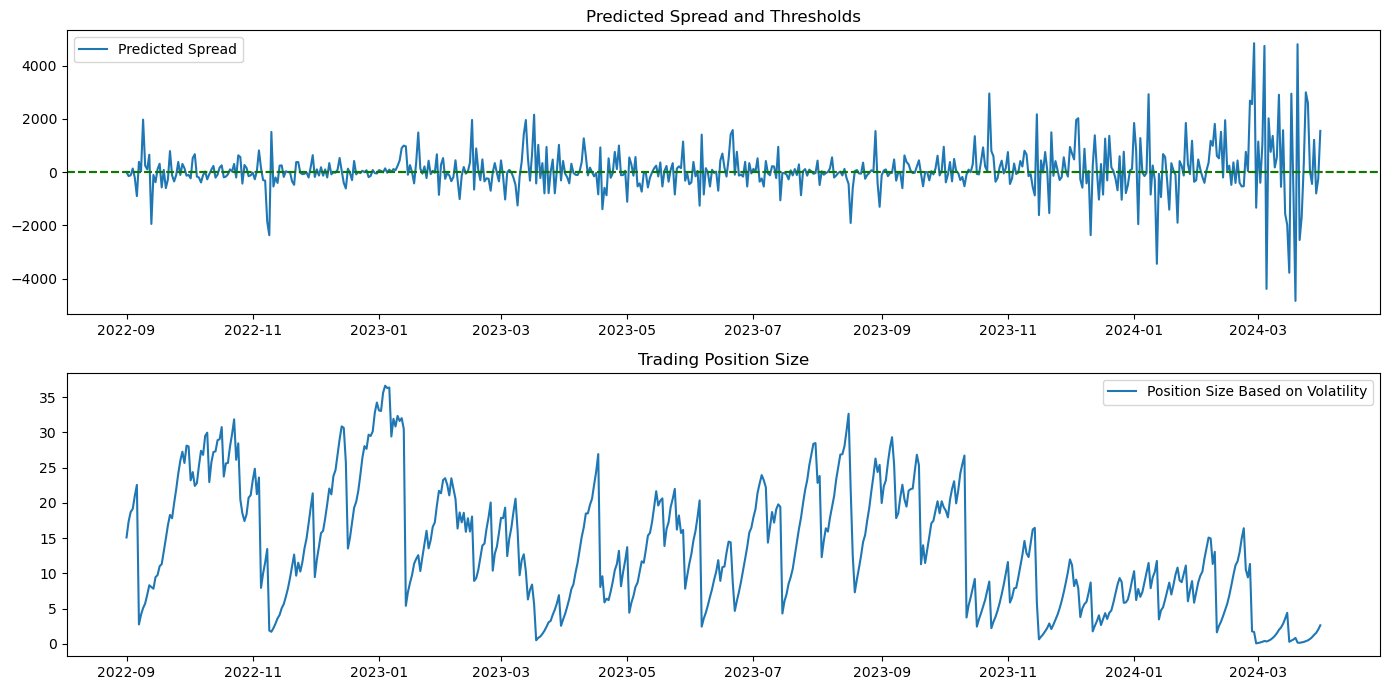

In [7]:
residuals = y - rf_model.predict(X)
# Fit EGARCH model for predicting volatility
garch = arch_model(residuals, vol='EGARCH', p=1, o=1, q=2, mean='Zero')
garch_fit = garch.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Trading signals based on predicted spreads
threshold = 1  # Adjust threshold based on your strategy
market_data['signal'] = np.where(market_data['predicted_spread'] > threshold, 'Long BTC / Short ETH', 'Short BTC / Long ETH')
market_data['signal'] = np.where(market_data['predicted_spread'] < -threshold, 'Long ETH / Short BTC', market_data['signal'])

# Position size based on predicted volatility
max_position_size = 100  # Maximum position size
market_data['position_size'] = max_position_size / (1 + market_data['predicted_volatility'])

# Display the trading strategy decision
print(market_data[['BTC_price', 'ETH_price', 'predicted_spread', 'predicted_volatility', 'signal', 'position_size']].tail())

# Visualization of the strategy decisions
plt.figure(figsize=(14, 7))
plt.subplot(211)
plt.plot(market_data.index, market_data['predicted_spread'], label='Predicted Spread')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='g', linestyle='--')
plt.title('Predicted Spread and Thresholds')
plt.legend()

plt.subplot(212)
plt.plot(market_data.index, market_data['position_size'], label='Position Size Based on Volatility')
plt.title('Trading Position Size')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# First, calculate the residuals from your Random Forest model
# Since you predicted the 'predicted_spread' directly, we assume y_test and the predictions are aligned in the index
residuals = y_test - rf_model.predict(X_test)

# Add a constant to the independent variables for the test
X_test_with_const = sm.add_constant(X_test)

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_test_with_const)

# Extract the test results
bp_test_stat, bp_p_value, bp_f_stat, bp_f_p_value = bp_test

# Print the results
print("Breusch-Pagan test statistic:", bp_test_stat)
print("Breusch-Pagan test p-value:", bp_p_value)
print("Breusch-Pagan F-statistic:", bp_f_stat)
print("Breusch-Pagan F-test p-value:", bp_f_p_value)

Breusch-Pagan test statistic: 61.044715359240804
Breusch-Pagan test p-value: 5.5501981082209896e-14
Breusch-Pagan F-statistic: 62.76059600715877
Breusch-Pagan F-test p-value: 4.662922433254873e-19


In [9]:
import statsmodels.api as sm

# Assuming 'garch_fit' is your fitted EGARCH model from the previous example
# Extract residuals from the EGARCH model
egarch_residuals = garch_fit.resid

# Perform the Ljung-Box test on the residuals to check for autocorrelation
# Test up to 10 lags, you can adjust this number based on your specific needs
lb_test = sm.stats.acorr_ljungbox(egarch_residuals, lags=[10], return_df=True)

# Print the results
print("Ljung-Box test results:")
print(lb_test)

Ljung-Box test results:
      lb_stat  lb_pvalue
10  40.078256   0.000016


# Visualising the Signals

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.438e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


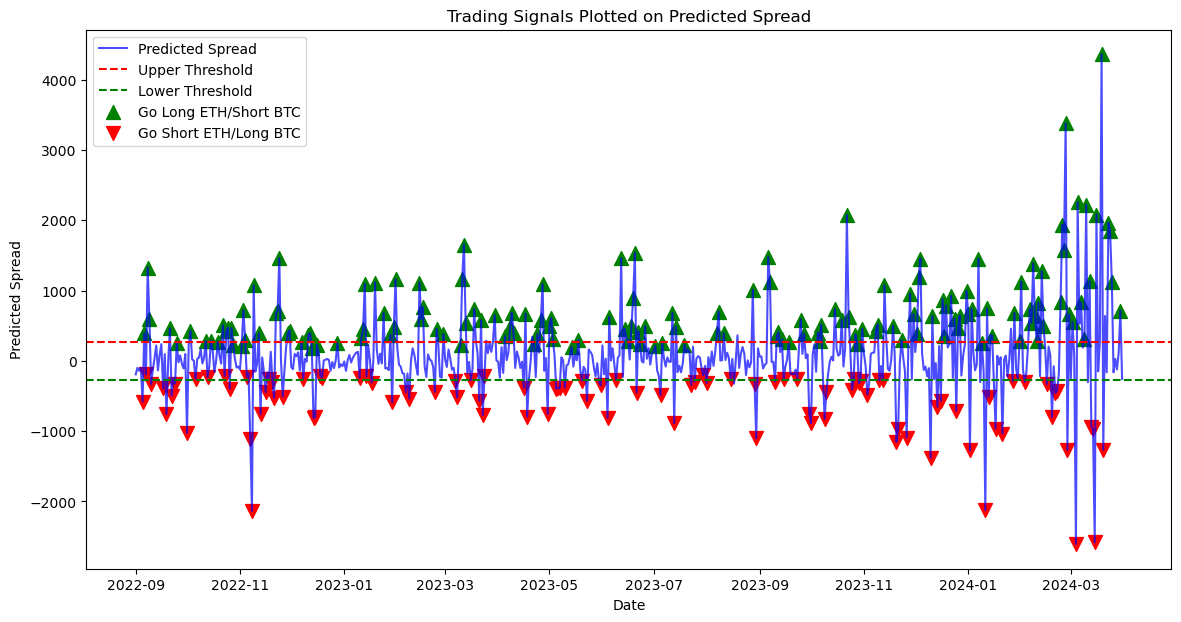

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.5  # Dynamic threshold factor based on volatility

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
def calculate_return(row):
    if row['signal'] == 'Long BTC / Short ETH':
        return row['BTC_daily_return'] - row['ETH_daily_return']
    elif row['signal'] == 'Short BTC / Long ETH':
        return row['ETH_daily_return'] - row['BTC_daily_return']
    return 0

market_data['strategy_return'] = market_data.apply(calculate_return, axis=1)

# Calculate cumulative returns and convert to percentage
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1

# Plotting the returns and signals
plt.figure(figsize=(14, 7))
plt.plot(market_data.index, market_data['predicted_spread'], label='Predicted Spread', color='blue', alpha=0.7)
plt.axhline(y=dynamic_threshold.mean(), color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=-dynamic_threshold.mean(), color='g', linestyle='--', label='Lower Threshold')
plt.scatter(market_data.index[market_data['signal'] == 'Long BTC / Short ETH'], market_data['predicted_spread'][market_data['signal'] == 'Long BTC / Short ETH'], color='green', label='Go Long ETH/Short BTC', marker='^', s=100)
plt.scatter(market_data.index[market_data['signal'] == 'Short BTC / Long ETH'], market_data['predicted_spread'][market_data['signal'] == 'Short BTC / Long ETH'], color='red', label='Go Short ETH/Long BTC', marker='v', s=100)
plt.title('Trading Signals Plotted on Predicted Spread')
plt.xlabel('Date')
plt.ylabel('Predicted Spread')
plt.legend()
plt.show()

# Backtesting

## 0.5 Dynamic threshold factor

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Sharpe Ratio: 0.7225
Cumulative Returns: 0.1941


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.75e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


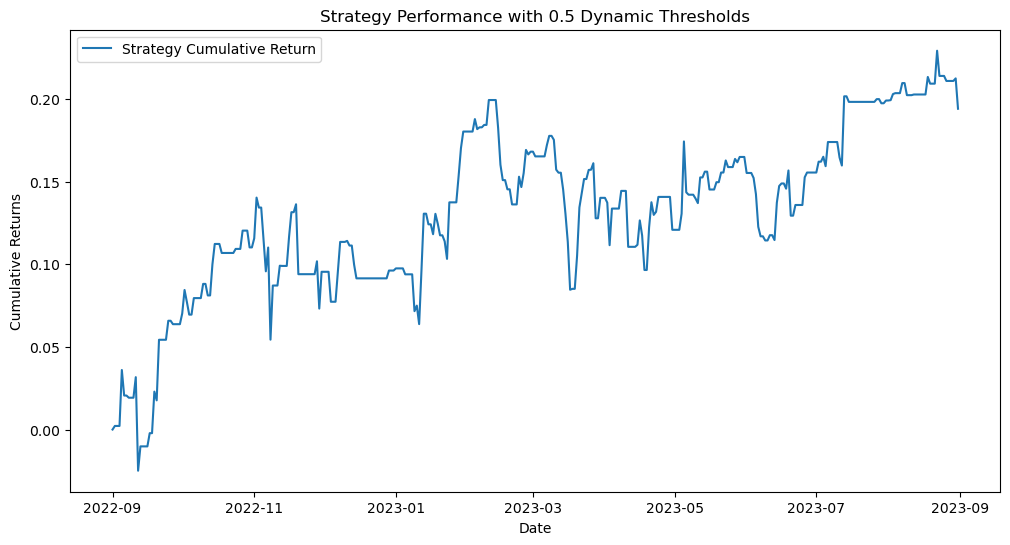

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.5  # Dynamic threshold factor based on volatility

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2023-09-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2023-09-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
def calculate_return(row):
    if row['signal'] == 'Long BTC / Short ETH':
        return row['BTC_daily_return'] - row['ETH_daily_return']
    elif row['signal'] == 'Short BTC / Long ETH':
        return row['ETH_daily_return'] - row['BTC_daily_return']
    return 0

market_data['strategy_return'] = market_data.apply(calculate_return, axis=1)

# Calculate cumulative returns and convert to percentage
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1

# Calculate the Sharpe Ratio
risk_free_rate = 0.02
mean_return = market_data['strategy_return'].mean() * 252
std_dev = market_data['strategy_return'].std() * np.sqrt(252)
sharpe_ratio = (mean_return - risk_free_rate) / std_dev

# Print the Sharpe Ratio and cumulative returns
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Cumulative Returns: {market_data['cumulative_strategy_return'].iloc[-1]:.4f}")

# Plotting the returns
plt.figure(figsize=(12, 6))
plt.plot(market_data.index, market_data['cumulative_strategy_return'], label='Strategy Cumulative Return')
plt.title('Strategy Performance with 0.5 Dynamic Thresholds')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


## With 0.05 Dynamic threshold

## 2022-2023

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Sharpe Ratio: 1.1873
Cumulative Returns: 0.4900


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.75e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


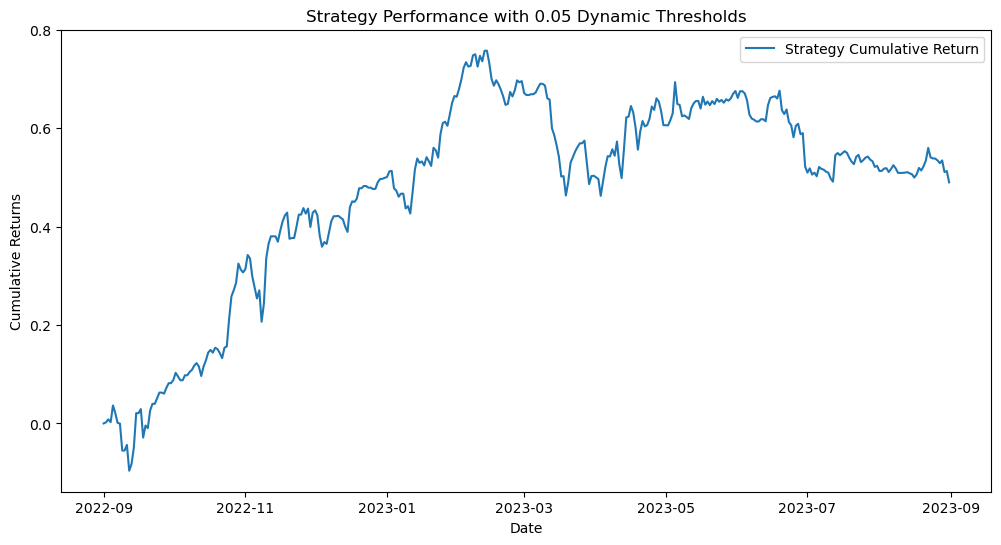

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.05  # Dynamic threshold factor based on volatility

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2023-09-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2023-09-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
def calculate_return(row):
    if row['signal'] == 'Long BTC / Short ETH':
        return row['BTC_daily_return'] - row['ETH_daily_return']
    elif row['signal'] == 'Short BTC / Long ETH':
        return row['ETH_daily_return'] - row['BTC_daily_return']
    return 0

market_data['strategy_return'] = market_data.apply(calculate_return, axis=1)

# Calculate cumulative returns and convert to percentage
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1

# Calculate the Sharpe Ratio
risk_free_rate = 0.02
mean_return = market_data['strategy_return'].mean() * 252
std_dev = market_data['strategy_return'].std() * np.sqrt(252)
sharpe_ratio = (mean_return - risk_free_rate) / std_dev

# Print the Sharpe Ratio and cumulative returns
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Cumulative Returns: {market_data['cumulative_strategy_return'].iloc[-1]:.4f}")

# Plotting the returns
plt.figure(figsize=(12, 6))
plt.plot(market_data.index, market_data['cumulative_strategy_return'], label='Strategy Cumulative Return')
plt.title('Strategy Performance with 0.05 Dynamic Thresholds')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


## 2022-2024

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Sharpe Ratio: 0.9975
Cumulative Returns: 0.7484


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.438e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


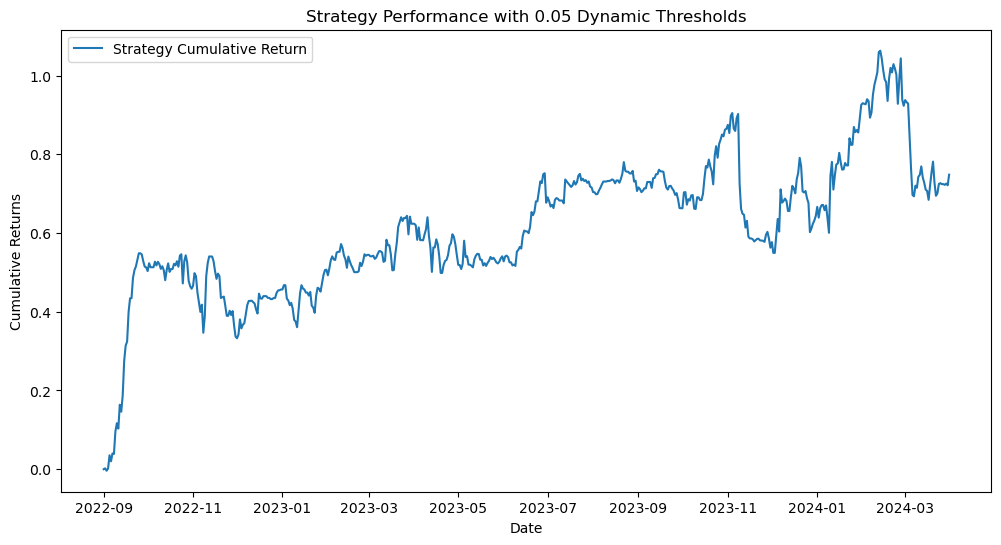

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.05  # Dynamic threshold factor based on volatility

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
def calculate_return(row):
    if row['signal'] == 'Long BTC / Short ETH':
        return row['BTC_daily_return'] - row['ETH_daily_return']
    elif row['signal'] == 'Short BTC / Long ETH':
        return row['ETH_daily_return'] - row['BTC_daily_return']
    return 0

market_data['strategy_return'] = market_data.apply(calculate_return, axis=1)

# Calculate cumulative returns and convert to percentage
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1

# Calculate the Sharpe Ratio
risk_free_rate = 0.02
mean_return = market_data['strategy_return'].mean() * 252
std_dev = market_data['strategy_return'].std() * np.sqrt(252)
sharpe_ratio = (mean_return - risk_free_rate) / std_dev

# Print the Sharpe Ratio and cumulative returns
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Cumulative Returns: {market_data['cumulative_strategy_return'].iloc[-1]:.4f}")

# Plotting the returns
plt.figure(figsize=(12, 6))
plt.plot(market_data.index, market_data['cumulative_strategy_return'], label='Strategy Cumulative Return')
plt.title('Strategy Performance with 0.05 Dynamic Thresholds')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


## Testing out of sample 2020-2022, a period where BTC and ETH are not Cointegrated

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Sharpe Ratio: 0.3122
Cumulative Returns: 0.1709


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.572e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


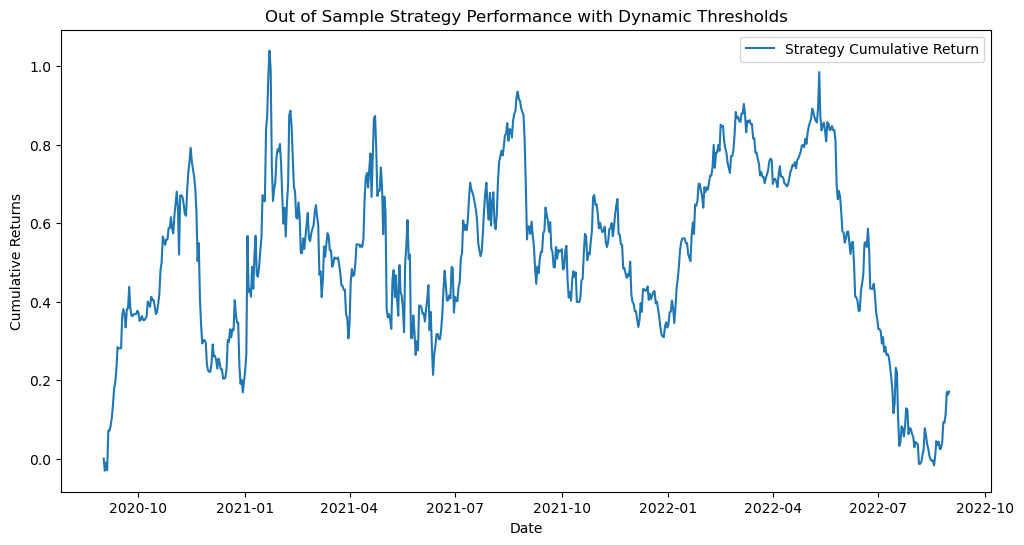

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.05  # Dynamic threshold factor based on volatility

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2020-09-01', end='2022-09-01')
eth_data = yf.download('ETH-USD', start='2020-09-01', end='2022-09-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
def calculate_return(row):
    if row['signal'] == 'Long BTC / Short ETH':
        return row['BTC_daily_return'] - row['ETH_daily_return']
    elif row['signal'] == 'Short BTC / Long ETH':
        return row['ETH_daily_return'] - row['BTC_daily_return']
    return 0

market_data['strategy_return'] = market_data.apply(calculate_return, axis=1)

# Calculate cumulative returns and convert to percentage
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1

# Calculate the Sharpe Ratio
risk_free_rate = 0.02
mean_return = market_data['strategy_return'].mean() * 252
std_dev = market_data['strategy_return'].std() * np.sqrt(252)
sharpe_ratio = (mean_return - risk_free_rate) / std_dev

# Print the Sharpe Ratio and cumulative returns
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Cumulative Returns: {market_data['cumulative_strategy_return'].iloc[-1]:.4f}")

# Plotting the returns
plt.figure(figsize=(12, 6))
plt.plot(market_data.index, market_data['cumulative_strategy_return'], label='Strategy Cumulative Return')
plt.title('Out of Sample Strategy Performance with Dynamic Thresholds')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [15]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Fetch historical prices for BTC and ETH
btc_data = yf.download('BTC-USD', start='2020-09-01', end='2022-09-01')['Close']
eth_data = yf.download('ETH-USD', start='2020-09-01', end='2022-09-01')['Close']  # Adjusted end date for alignment

# Combine into a single DataFrame
prices = pd.DataFrame({'BTC': btc_data, 'ETH': eth_data}).dropna()

# Engle-Granger cointegration test
score, p_value, _ = coint(prices['BTC'], prices['ETH'])

# Display the test results
print(f"Cointegration test score: {score}")
print(f"P-value: {p_value}")

# Interpretation of results
if p_value < 0.05:
    print("The series are likely cointegrated.")
else:
    print("The series are not likely cointegrated.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Cointegration test score: -1.4361549480540865
P-value: 0.7848519153776826
The series are not likely cointegrated.


## Performance evaluation for period of 2022-2024

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
BTC Cumulative Returns: 2.5442
BTC Sharpe Ratio: 1.5040
ETH Cumulative Returns: 1.2998
ETH Sharpe Ratio: 0.9615
Strategy Cumulative Returns: 0.7484
Strategy Sharpe Ratio: 0.9975


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.438e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


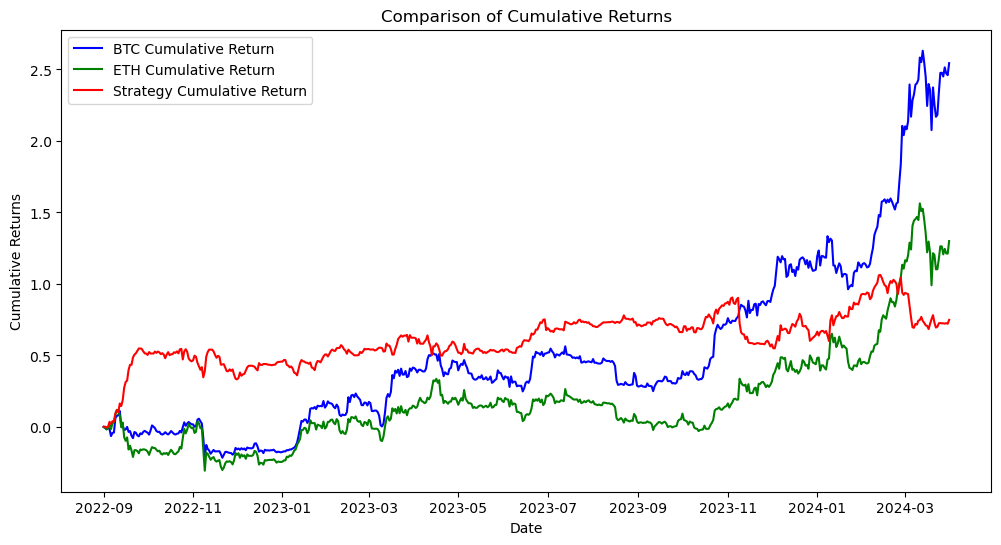

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.05  # Dynamic threshold factor based on volatility
risk_free_rate = 0.02  # Risk-free rate for Sharpe ratio calculation
trading_days = 252  # Number of trading days in a year

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Calculate cumulative returns for BTC and ETH
market_data['BTC_cumulative_return'] = (1 + market_data['BTC_daily_return']).cumprod() - 1
market_data['ETH_cumulative_return'] = (1 + market_data['ETH_daily_return']).cumprod() - 1

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
market_data['strategy_return'] = market_data.apply(calculate_return, axis=1)

# Calculate cumulative returns and convert to percentage
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1

# Calculate Sharpe Ratios
btc_sharpe_ratio = (market_data['BTC_daily_return'].mean() * trading_days - risk_free_rate) / (market_data['BTC_daily_return'].std() * np.sqrt(trading_days))
eth_sharpe_ratio = (market_data['ETH_daily_return'].mean() * trading_days - risk_free_rate) / (market_data['ETH_daily_return'].std() * np.sqrt(trading_days))
strategy_sharpe_ratio = (market_data['strategy_return'].mean() * trading_days - risk_free_rate) / (market_data['strategy_return'].std() * np.sqrt(trading_days))

# Print cumulative returns and Sharpe ratios
print(f"BTC Cumulative Returns: {market_data['BTC_cumulative_return'].iloc[-1]:.4f}")
print(f"BTC Sharpe Ratio: {btc_sharpe_ratio:.4f}")
print(f"ETH Cumulative Returns: {market_data['ETH_cumulative_return'].iloc[-1]:.4f}")
print(f"ETH Sharpe Ratio: {eth_sharpe_ratio:.4f}")
print(f"Strategy Cumulative Returns: {market_data['cumulative_strategy_return'].iloc[-1]:.4f}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")

# Plotting the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(market_data.index, market_data['BTC_cumulative_return'], label='BTC Cumulative Return', color='blue')
plt.plot(market_data.index, market_data['ETH_cumulative_return'], label='ETH Cumulative Return', color='green')
plt.plot(market_data.index, market_data['cumulative_strategy_return'], label='Strategy Cumulative Return', color='red')
plt.title('Comparison of Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model
from scipy.stats import norm

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.05  # Dynamic threshold factor based on volatility
risk_free_rate = 0.02  # Risk-free rate for Sharpe ratio calculation
trading_days = 252  # Number of trading days in a year

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Calculate cumulative returns for BTC and ETH
market_data['BTC_cumulative_return'] = (1 + market_data['BTC_daily_return']).cumprod() - 1
market_data['ETH_cumulative_return'] = (1 + market_data['ETH_daily_return']).cumprod() - 1

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
market_data['strategy_return'] = market_data.apply(lambda row: row['BTC_daily_return'] - row['ETH_daily_return'] if row['signal'] == 'Long BTC / Short ETH' else (row['ETH_daily_return'] - row['BTC_daily_return'] if row['signal'] == 'Short BTC / Long ETH' else 0), axis=1)

# Calculate cumulative returns and annualized returns
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1
annualized_strategy_return = ((1 + market_data['cumulative_strategy_return'].iloc[-1]) ** (trading_days / market_data.shape[0])) - 1

# Calculate volatility
btc_volatility = market_data['BTC_daily_return'].std() * np.sqrt(trading_days)
eth_volatility = market_data['ETH_daily_return'].std() * np.sqrt(trading_days)
strategy_volatility = market_data['strategy_return'].std() * np.sqrt(trading_days)

# Sharpe Ratio
strategy_sharpe_ratio = (market_data['strategy_return'].mean() * trading_days - risk_free_rate) / strategy_volatility
btc_sharpe_ratio = (market_data['BTC_daily_return'].mean() * trading_days - risk_free_rate) / btc_volatility
eth_sharpe_ratio = (market_data['ETH_daily_return'].mean() * trading_days - risk_free_rate) / eth_volatility

# VaR and CVaR
confidence_level = 0.95
strategy_var = norm.ppf(1 - confidence_level, market_data['strategy_return'].mean(), market_data['strategy_return'].std())
strategy_cvar = market_data['strategy_return'][market_data['strategy_return'] <= strategy_var].mean()

# Maximum Drawdown
rolling_max = market_data['cumulative_strategy_return'].cummax()
drawdown = market_data['cumulative_strategy_return'] - rolling_max
max_drawdown = drawdown.min()

# Print all metrics
print(f"BTC Cumulative Returns: {market_data['BTC_cumulative_return'].iloc[-1]:.4f}, Annualized Return: {((1 + market_data['BTC_cumulative_return'].iloc[-1]) ** (trading_days / len(market_data)) - 1):.4f}, Sharpe Ratio: {btc_sharpe_ratio:.4f}, Volatility: {btc_volatility:.4f}, VaR: {norm.ppf(1 - confidence_level, market_data['BTC_daily_return'].mean(), btc_volatility):.4f}, CVaR: {market_data['BTC_daily_return'][market_data['BTC_daily_return'] <= norm.ppf(1 - confidence_level, market_data['BTC_daily_return'].mean(), btc_volatility)].mean():.4f}")
print(f"ETH Cumulative Returns: {market_data['ETH_cumulative_return'].iloc[-1]:.4f}, Annualized Return: {((1 + market_data['ETH_cumulative_return'].iloc[-1]) ** (trading_days / len(market_data)) - 1):.4f}, Sharpe Ratio: {eth_sharpe_ratio:.4f}, Volatility: {eth_volatility:.4f}, VaR: {norm.ppf(1 - confidence_level, market_data['ETH_daily_return'].mean(), eth_volatility):.4f}, CVaR: {market_data['ETH_daily_return'][market_data['ETH_daily_return'] <= norm.ppf(1 - confidence_level, market_data['ETH_daily_return'].mean(), eth_volatility)].mean():.4f}")
print(f"Strategy Cumulative Returns: {market_data['cumulative_strategy_return'].iloc[-1]:.4f}, Annualized Returns: {annualized_strategy_return:.4f}, Sharpe Ratio: {strategy_sharpe_ratio:.4f}, Volatility: {strategy_volatility:.4f}, VaR: {strategy_var:.4f}, CVaR: {strategy_cvar:.4f}, Maximum Drawdown: {max_drawdown:.4f}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
BTC Cumulative Returns: 2.5442, Annualized Return: 0.7361, Sharpe Ratio: 1.5040, Volatility: 0.4093, VaR: -0.6707, CVaR: nan
ETH Cumulative Returns: 1.2998, Annualized Return: 0.4378, Sharpe Ratio: 0.9615, Volatility: 0.4741, VaR: -0.7779, CVaR: nan
Strategy Cumulative Returns: 0.7484, Annualized Returns: 0.2758, Sharpe Ratio: 0.9975, Volatility: 0.2573, VaR: -0.0256, CVaR: -0.0389, Maximum Drawdown: -0.3789


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.438e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model
from scipy.stats import norm

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.05  # Dynamic threshold factor based on volatility
risk_free_rate = 0.02  # Risk-free rate for Sharpe ratio calculation (2%)
trading_days = 252  # Number of trading days in a year

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Calculate cumulative returns for BTC and ETH
market_data['BTC_cumulative_return'] = (1 + market_data['BTC_daily_return']).cumprod() - 1
market_data['ETH_cumulative_return'] = (1 + market_data['ETH_daily_return']).cumprod() - 1

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
market_data['strategy_return'] = market_data.apply(lambda row: row['BTC_daily_return'] - row['ETH_daily_return'] if row['signal'] == 'Long BTC / Short ETH' else (row['ETH_daily_return'] - row['BTC_daily_return'] if row['signal'] == 'Short BTC / Long ETH' else 0), axis=1)

# Calculate cumulative returns and annualized returns
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1
annualized_strategy_return = ((1 + market_data['cumulative_strategy_return'].iloc[-1]) ** (trading_days / market_data.shape[0])) - 1

# Calculate volatility
btc_volatility = market_data['BTC_daily_return'].std() * np.sqrt(trading_days)
strategy_volatility = market_data['strategy_return'].std() * np.sqrt(trading_days)

# Beta calculation
btc_beta = market_data['strategy_return'].cov(market_data['BTC_daily_return']) / market_data['BTC_daily_return'].var()

# Alpha calculation (using CAPM formula)
btc_annual_return = ((1 + market_data['BTC_cumulative_return'].iloc[-1]) ** (trading_days / len(market_data)) - 1)
strategy_alpha = annualized_strategy_return - (risk_free_rate + btc_beta * (btc_annual_return - risk_free_rate))

# Print Beta and Alpha
print(f"Strategy Beta relative to BTC: {btc_beta:.4f}")
print(f"Strategy Alpha: {strategy_alpha:.4f}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Strategy Beta relative to BTC: 0.0642
Strategy Alpha: 0.2099


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.438e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## Including transaction costs

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Sharpe Ratio: -16.0671
Cumulative Returns: -1.0000


/Volumes/UCL/PYTHON/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.438e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


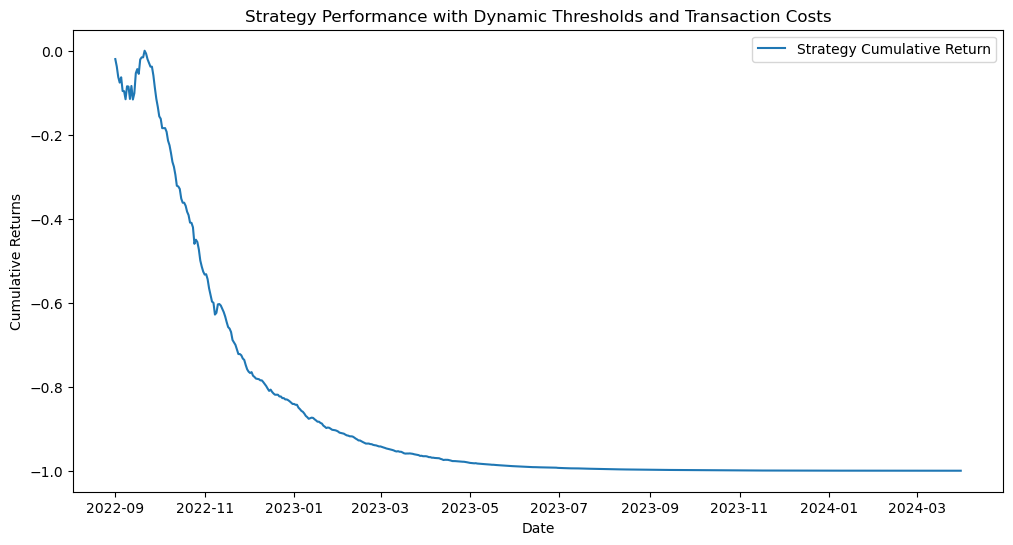

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from arch import arch_model

# Constants for dynamic risk management
MIN_POSITION_SIZE = 0.1  # Minimum position size
dynamic_threshold_factor = 0.05  # Dynamic threshold factor based on volatility
transaction_cost = 0.01  # 1% transaction cost per trade

# Download historical data for BTC and ETH
btc_data = yf.download('BTC-USD', start='2022-09-01', end='2024-04-01')
eth_data = yf.download('ETH-USD', start='2022-09-01', end='2024-04-01')

# Prepare the DataFrame
market_data = pd.DataFrame({
    'BTC_price': btc_data['Close'],
    'ETH_price': eth_data['Close']
})
market_data['Spread'] = market_data['BTC_price'] - market_data['ETH_price']
market_data['Differenced_Spread'] = market_data['Spread'].diff().fillna(0)
market_data['BTC_daily_return'] = market_data['BTC_price'].pct_change().fillna(0)
market_data['ETH_daily_return'] = market_data['ETH_price'].pct_change().fillna(0)

# Split data for training and testing
X = market_data[['Differenced_Spread']]
y = market_data['Differenced_Spread'].shift(-1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model for predicting the spread
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
market_data['predicted_spread'] = rf_model.predict(X)

# Calculate residuals for EGARCH
residuals = y - rf_model.predict(X)
garch_model = arch_model(residuals, mean='Zero', vol='EGarch', p=1, o=1, q=2)
garch_fit = garch_model.fit(disp='off')
market_data['predicted_volatility'] = garch_fit.conditional_volatility

# Define signals based on predicted spread and volatility-adjusted threshold
dynamic_threshold = market_data['predicted_volatility'] * dynamic_threshold_factor
market_data['signal'] = np.where(
    market_data['predicted_spread'] > dynamic_threshold, 'Long BTC / Short ETH',
    np.where(market_data['predicted_spread'] < -dynamic_threshold, 'Short BTC / Long ETH', 'No Position')
)

# Calculate strategy returns based on positions
def calculate_adjusted_return(row):
    if row['signal'] == 'Long BTC / Short ETH' or row['signal'] == 'Short BTC / Long ETH':
        # Adjust the return by subtracting the transaction cost for opening and closing the position
        net_return = row['BTC_daily_return'] - row['ETH_daily_return'] - 2 * transaction_cost if row['signal'] == 'Long BTC / Short ETH' else row['ETH_daily_return'] - row['BTC_daily_return'] - 2 * transaction_cost
        return net_return
    return 0

market_data['strategy_return'] = market_data.apply(calculate_adjusted_return, axis=1)

# Calculate cumulative returns and convert to percentage
market_data['cumulative_strategy_return'] = (1 + market_data['strategy_return']).cumprod() - 1

# Calculate the Sharpe Ratio
risk_free_rate = 0.02
mean_return = market_data['strategy_return'].mean() * 252
std_dev = market_data['strategy_return'].std() * np.sqrt(252)
sharpe_ratio = (mean_return - risk_free_rate) / std_dev

# Print the Sharpe Ratio and cumulative returns
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Cumulative Returns: {market_data['cumulative_strategy_return'].iloc[-1]:.4f}")

# Plotting the returns
plt.figure(figsize=(12, 6))
plt.plot(market_data.index, market_data['cumulative_strategy_return'], label='Strategy Cumulative Return')
plt.title('Strategy Performance with Dynamic Thresholds and Transaction Costs')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
